In [20]:
# STEP 0: SETUP AND IMPORTS
# This cell now imports your functions directly from ai_core.py

import os
import json
import getpass
from dotenv import load_dotenv
import ipywidgets as widgets
from IPython.display import display, Markdown
from PIL import Image

from ai_core import (
    get_identified_object,
    generate_spark_content,
    get_normalized_stem_skills,
    get_pathfinder_guidance,
    get_ai_tutor_response
)

load_dotenv()
try:
    api_key = os.getenv("GEMINI_API_KEY")
    if not api_key:
        api_key = getpass.getpass('GEMINI_API_KEY not found. Please enter it here: ')
    
    print(" Functions imported and ready to use.")
    if not os.getenv("GEMINI_API_KEY"):
         print("Note: API Key was entered manually.")

except Exception as e:
    print(f"An error occurred during setup: {e}")


uploaded_image_path = None
selected_grade_level = None
identified_object = None
spark_content = None
normalized_skills = None
user_skills_for_pathfinder = {}
tutor_chat_history = []

 Functions imported and ready to use.


In [21]:
# Step 1: Provide Inputs
# Select a grade level and upload an image file using the widgets below. After uploading, run the next cell to process the image.
grade_level_dropdown = widgets.Dropdown(
    options=['Elementary', 'Junior High School', 'Senior High School'],
    value='Junior High School',
    description='Grade Level:',
    disabled=False,
)

uploader = widgets.FileUpload(
    accept='image/*', 
    multiple=False,
    description='Upload Image'
)

print("Please select a grade level and upload an image:")

display(grade_level_dropdown, uploader)

Please select a grade level and upload an image:


Dropdown(description='Grade Level:', index=1, options=('Elementary', 'Junior High School', 'Senior High School…

FileUpload(value=(), accept='image/*', description='Upload Image')

✅ Grade Level set to: Junior High School
✅ Image 'light-bulb-hanging-ceiling-empty-260nw-1588020007.png' ready for processing.


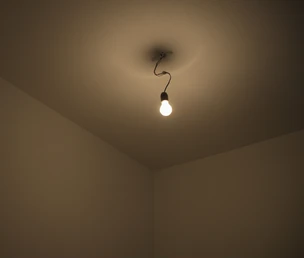


🔬 Identifying object in the image...


### 👁️ Object Identification Result:

**Object Label:** `Light Bulb`

**Category Hint:** `technology`

In [22]:
# Step 2: Process Inputs and Identify Object
# This cell takes the uploaded file, saves it temporarily, and runs `get_identified_object`.

if uploader.value:
    # --- Process the uploaded file ---
    uploaded_file_info = uploader.value[0]
    file_content = uploaded_file_info['content']
    file_name = uploaded_file_info['name']
    
    # Save the file temporarily to be used by the functions
    with open(file_name, 'wb') as f:
        f.write(file_content)
    
    uploaded_image_path = file_name
    selected_grade_level = grade_level_dropdown.value
    
    print(f"✅ Grade Level set to: {selected_grade_level}")
    print(f"✅ Image '{uploaded_image_path}' ready for processing.")
    
    # --- Display the image ---
    display(Image.open(uploaded_image_path))

    # --- Run Identification ---
    print("\n🔬 Identifying object in the image...")
    identified_object = get_identified_object(uploaded_image_path)
    
    if identified_object:
        display(Markdown("### 👁️ Object Identification Result:"))
        display(Markdown(f"**Object Label:** `{identified_object.get('object_label')}`"))
        display(Markdown(f"**Category Hint:** `{identified_object.get('category_hint')}`"))
    else:
        print("❌ Could not identify the object.")
else:
    print("⚠️ Please upload a file in the cell above and re-run this cell.")

In [23]:
# Step 3: Generate "Spark" Educational Content
# This cell runs `generate_spark_content` using the identified object and selected grade level.

if identified_object and selected_grade_level:
    print("✨ Generating 'Spark' content...")
    spark_content = generate_spark_content(identified_object, selected_grade_level)
    
    if spark_content:
        display(Markdown("---"))
        display(Markdown("### 💡 Quick Facts"))
        display(Markdown(spark_content.get('quick_facts', '')))
        
        display(Markdown("### 🔬 STEM Concepts"))
        display(Markdown(spark_content.get('stem_concepts', '')))
        
        display(Markdown("### 🛠️ Hands-On Project"))
        display(Markdown(spark_content.get('hands_on_project', '')))
        display(Markdown("---"))
    else:
        print("❌ Could not generate Spark content.")
else:
    print("⚠️ Please run the previous steps first.")

✨ Generating 'Spark' content...


---

### 💡 Quick Facts

Hey Tuklas-Kada! Ever wondered how we can just flip a switch and light up a whole room? We have the light bulb to thank for that! For over a century, these glass marvels have turned our nights into day, letting us study, work, and play even after the sun has set. While many people credit Thomas Edison with the invention, he actually perfected a design that could last for a long time. Here's a mind-blowing fact: old-school incandescent light bulbs are actually more like heaters than lighters! About 90% of the electricity they use is converted into heat, and only 10% becomes the light you actually see. Grabe, 'di ba?

### 🔬 STEM Concepts

So, paano nga ba gumagana ang isang bumbilya? It's all about amazing science! Let's break it down.

### The Magic of Resistance
Imagine trying to run through a super crowded hallway sa school. Ang hirap, 'di ba? You bump into people and create a lot of friction and heat. That's similar to what happens inside an old-school incandescent bulb! Electricity flows through a very thin wire called a **filament**, which is usually made of a metal called tungsten. This filament *resists* the flow of electricity. This resistance causes the filament to get incredibly hot—so hot that it glows brightly! This process of making light with heat is called **incandescence**.

### Why Doesn't It Just Burn Up?
If you heat a thin wire in the open air, it would just burn out in a flash—poof! So why doesn't the filament in a light bulb? The secret is what's inside the glass bulb. It’s not just empty space; it's filled with an **inert gas**, like argon or nitrogen. "Inert" means these gases don't react with other elements. This gas blanket prevents oxygen from reaching the super-hot filament, protecting it from burning and allowing it to glow for hundreds of hours.

### Level Up: From Hot Bulbs to Cool LEDs
Today, we often use **LED (Light Emitting Diode)** bulbs. They are the rockstars of the lighting world! Instead of using heat to produce light, LEDs work by passing electricity through a tiny material called a semiconductor. This process releases photons (particles of light) directly. It's way more efficient, which means it uses less electricity (nakakatipid sa kuryente!) and produces very little heat. That’s why you can touch an LED bulb even when it’s on, but you should never, ever touch an old incandescent bulb!

### 🛠️ Hands-On Project

### Project: Gawing Baterya ang Kamote!

Let's make a simple circuit to understand how electricity can power a light. We won't build a full light bulb, but we can use a potato or sweet potato (kamote) to power a small LED! Astig!

**Mga Kailangan (Materials):**
*   1 malaking Kamote o Patatas (Sweet Potato or Potato)
*   1 bagong 1-Peso coin (the newer silver one)
*   1 galvanized nail (pako) or a large metal paperclip
*   1 small LED light (you can get this from an old toy or keychain)

**Mga Hakbang (Steps):**
1.  Carefully cut two small slits in your kamote, about one inch apart. Make sure the slits are deep enough to hold your coin and nail securely.
2.  Push the 1-Peso coin firmly into one slit. Push the nail into the other slit. **Important:** Make sure the coin and the nail do not touch each other inside the kamote!
3.  The coin and the nail are your **electrodes**. The juice inside the kamote acts as an **electrolyte**, a special liquid that helps get the electricity moving. Together, they create a simple battery!
4.  Now, get your small LED. It has two little metal legs called leads. Touch one lead to the coin and the other lead to the head of the nail.
5.  Voila! The LED should light up faintly. If it doesn't, try swapping the legs. LEDs only work when electricity flows in one direction, so baka baliktad lang ang pagkakakabit mo.
6.  You just created a complete circuit powered by a vegetable! This tiny bit of electricity is perfectly safe to touch. Galing!

---

In [26]:
# Step 4: Extract STEM Skills and Test Pathfinder
# 1.  Runs `get_normalized_stem_skills` on the content from Step 3.
# 2.  Runs `get_pathfinder_guidance` using the extracted skills.

import random

if spark_content and selected_grade_level:
    # --- Part 1: Skill Extraction ---
    print("🌿 Extracting and normalizing STEM skills...")
    normalized_skills = get_normalized_stem_skills(spark_content)
    
    if normalized_skills:
        display(Markdown("### 🌳 Extracted Skills for Skill Tree:"))
        for skill in normalized_skills:
            display(Markdown(f"- **{skill.get('skill_name')}** (Category: *{skill.get('category')}*)"))
        
        # --- Part 2: Pathfinder Guidance ---
        # For testing, create a dummy skills dict with random mastery
        user_skills_for_pathfinder = {skill['skill_name']: random.randint(40, 95) for skill in normalized_skills}
        
        print("\n🧭 Generating Pathfinder guidance with the following skills profile:")
        print(json.dumps(user_skills_for_pathfinder, indent=2))

        pathfinder_guidance = get_pathfinder_guidance(user_skills_for_pathfinder, selected_grade_level)
        
        if pathfinder_guidance:
            display(Markdown("---"))
            display(Markdown(f"## 🧭 {pathfinder_guidance.get('title')}"))
            display(Markdown(f"_{pathfinder_guidance.get('summary')}_"))

            if pathfinder_guidance.get("recommendations"):
                 for rec in pathfinder_guidance.get("recommendations"):
                    display(Markdown(f"### Recommendation: {rec.get('name')}"))
                    display(Markdown(f"**Why?** {rec.get('why')}"))
                    if "whats_next" in rec:
                        display(Markdown(f"**What to Expect:** {rec.get('whats_next')}"))
                    if "career_paths" in rec:
                        display(Markdown(f"**Potential Careers:** {', '.join(rec.get('career_paths', []))}"))
                    if "local_spotlight" in rec:
                        display(Markdown(f"**Local Universities:** {', '.join(rec.get('local_spotlight', []))}"))
                    if "inspiration" in rec:
                        display(Markdown(f"**Inspiration:** {rec['inspiration'].get('name')}, {rec['inspiration'].get('description')}"))
            else:
                display(Markdown("No specific recommendations generated for this grade level, as expected."))
        else:
            print("❌ Could not generate Pathfinder guidance.")
    else:
        print("❌ Could not extract STEM skills.")
else:
    print("⚠️ Please run the previous steps first.")

🌿 Extracting and normalizing STEM skills...


### 🌳 Extracted Skills for Skill Tree:

- **Electricity & Circuits** (Category: *Physics*)

- **Energy Conversion** (Category: *Physics*)

- **Semiconductor Physics** (Category: *Physics*)

- **Optics** (Category: *Physics*)

- **Electrochemistry** (Category: *Chemistry*)

- **Chemical Reactivity** (Category: *Chemistry*)

- **Engineering Design** (Category: *Engineering*)

- **Bioelectricity** (Category: *Biology*)


🧭 Generating Pathfinder guidance with the following skills profile:
{
  "Electricity & Circuits": 45,
  "Energy Conversion": 69,
  "Semiconductor Physics": 63,
  "Optics": 58,
  "Electrochemistry": 92,
  "Chemical Reactivity": 54,
  "Engineering Design": 91,
  "Bioelectricity": 77
}
Error: Prompt file not found at d:\Hackathon\Tuklascope\ai_functions\prompts\ai_pathfinder_guidance_prompt.prompt
❌ Could not generate Pathfinder guidance.


In [ ]:
# Step 5: Test the AI Tutor (Interactive)
# Run this cell to ask a question. You can run it multiple times to simulate a conversation. The chat history is maintained between runs.

if selected_grade_level:
    object_context = identified_object.get('object_label') if identified_object else "the scanned object"
    
    user_question = input(f"Ask TuklasTutor about '{object_context}' or anything else: ")

    if user_question:
        # Add user's message to history
        tutor_chat_history.append({"role": "user", "parts": user_question})
        
        print("\n💬 Thinking...")
        ai_response = get_ai_tutor_response(
            user_question=user_question,
            grade_level=selected_grade_level,
            chat_history=tutor_chat_history,
            object_context=object_context
        )
        
        if ai_response:
            display(Markdown("---"))
            display(Markdown(f"**You:** {user_question}"))
            display(Markdown(f"**TuklasTutor:** {ai_response}"))
            display(Markdown("---"))
            
            # Add AI's response to history
            tutor_chat_history.append({"role": "model", "parts": ai_response})
        else:
            print("❌ Tutor did not provide a response.")
            # Remove user question from history if tutor fails
            tutor_chat_history.pop()
else:
    print("⚠️ Please run the previous steps first.")